# Train models based on balanced dataset
## Read the dataset
The here used dataset is a version with selected features based on the EDA and feature selection. See EDA_Feature_Selection notebook for the reasoning of choices made.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

C:\Users\chiar\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('parkinson_feature_selection.csv')
df = df.iloc[: , 1:]
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(Abs),HNR,RPDE,D2,DFA,spread2,status
0,119.992,157.302,74.997,0.00007,21.033,0.414783,2.301442,0.815285,0.266482,1
1,122.400,148.650,113.819,0.00008,19.085,0.458359,2.486855,0.819521,0.335590,1
2,116.682,131.111,111.555,0.00009,20.651,0.429895,2.342259,0.825288,0.311173,1
3,116.676,137.871,111.366,0.00009,20.644,0.434969,2.405554,0.819235,0.334147,1
4,116.014,141.781,110.655,0.00011,19.649,0.417356,2.332180,0.823484,0.234513,1


## Prepare the data

In [3]:
# store target variable y
y = df.status.values

# create feature matrix
X = np.array(df.loc[ : , df.columns != 'status']) # these are the features (matrix)
X.shape

(195, 9)

In [4]:
# Normalize the data
def normalize(X):
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    return X

X = normalize(X)

## Conduct group balancing

There are two options to balance the groups:
- undersampling: reduce samples in the majority class 
- oversampling: increase number of samples in the minority class 
Undersampling may discard a lot of information while oversampling might be a costly task to conduct. Undersampling could be conducted using TOMEK technique, which picks quite close data points from opposite classes (pairs) and discards the points from each pair which belongs to the majority class. Here this would lead to loss of a lot of data so oversampling is prefered. Here conducted is the SMOTE technique, which measures the distances between the minority class and creates synthetic observations inbetween adjacent observations from the minority class [https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/].

In [5]:
def make_barplot(y):
    ar_unique, counts = np.unique(y, return_counts = True)
    plt.bar(ar_unique, counts)
    plt.show()
    print(counts)

Original dataset shape (195,)


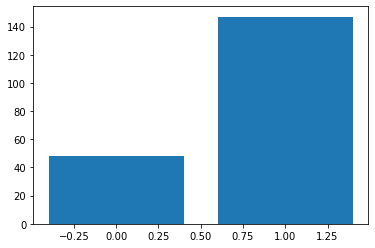

[ 48 147]
Resample dataset shape (294,)


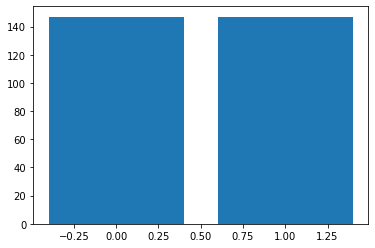

[147 147]


In [6]:
# build smote model
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

# print the original data shape
print('Original dataset shape', y.shape)
make_barplot(y)

# print resampled data shape
print('Resample dataset shape', y_smote.shape)
make_barplot(y_smote)

# Built, train and evaluate models
Several classifiers are build: 
- logistic regression
- naive Bayes
- XGBoost 

The models are split into 80% training data and 20% test/validation dataset. 

The evaluation metrics used here are accuracy (to get an impression of the overall accuracy, it is a suitable measure here because groups were balanced prior to modelling). Further the confusion matrix is computed. From the confusion matrix especially the False negative predictions are important to check, because it would result in a lot of other diagnostics conducted to find the reason for the dysphonia apart from Parkinson. False positives are more acceptable, because a following MRI scan could verify the diagnosis. Since a lof False negative rate is desired recall measure is an important measure too.  

In medical diagnostics a gold standard for accuracy is 95%, which is desired to achieve here as well. Moreover, the number of false negative predictions should be very small. Further, recall should be above 80%. 

In [7]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = .2, random_state = 1)

In [8]:
# predefine some functions to evaluate the models

# evaluation metrics
def evaluate(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# learning curve
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    """
    input:
        model:pipeline object
        X_train, y_train: training data
        X_val, y_val: test data
    """
    train_errors, val_errors = [], []
    for m in range(30, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=1, label="training data")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=1, label="validation data")
    plt.legend(loc="upper right", fontsize=10)   
    plt.xlabel("Training set size", fontsize=10) 
    plt.ylabel("RMSE", fontsize=10)     
    # compare accuracy train versus test to access overfit 
    print(f'test  acc: {model.score(X_val, y_val)}')
    print(f'train acc: {model.score(X_train, y_train)}')

### Simple models
First simple algorithms were applied, which are preferred to use due to saving computational resources and time. Moreover, they are more insightful and may reveal patterns/rules human can apply to classify as well. This is especially interesting when prediciting in medical diagnostics. Here it would be nice if we can make sense of the most influencial features or there weights. 

#### Logistic regression
The logistic regression model was here used as an baseline classifier.

[[22  7]
 [ 7 23]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        29
           1       0.77      0.77      0.77        30

    accuracy                           0.76        59
   macro avg       0.76      0.76      0.76        59
weighted avg       0.76      0.76      0.76        59

-0.1851  MDVP:Fo(Hz)
-0.3075  MDVP:Fhi(Hz)
-0.2624  MDVP:Flo(Hz)
0.2898  MDVP:Jitter(Abs)
-0.3209  HNR
0.232  RPDE
1.084  D2
0.4436  DFA
0.615  spread2
test  acc: 0.7627118644067796
train acc: 0.7404255319148936


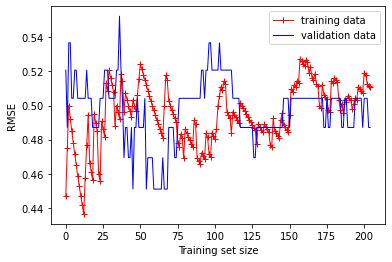

In [9]:
# logistic regression
# train the model
logreg = LogisticRegression(random_state = 1)
logreg_model = logreg.fit(X_train, y_train)

# make prediction
y_pred = logreg.predict(X_test)

# evaluate models predcitions
evaluate(y_test, y_pred)

# print the weights
for i in logreg.coef_:
       for index, j in enumerate(i):        
            print(f"{j:.4}  {list(df.columns.values)[index]}")

# plot learning curve
plot_learning_curves(logreg_model, X_train, y_train, X_test, y_test)

It has an accuracy around 74%, which is far below the desired 95%. Recall is pretty low for one of the class as well. There are also quite a lot (12) false negative predictions. Learning curve does show that the performance is improving with providing more trainings data. 

[[21  8]
 [ 7 23]]
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        29
           1       0.74      0.77      0.75        30

    accuracy                           0.75        59
   macro avg       0.75      0.75      0.75        59
weighted avg       0.75      0.75      0.75        59

test  acc: 0.7288135593220338
train acc: 0.7404255319148936


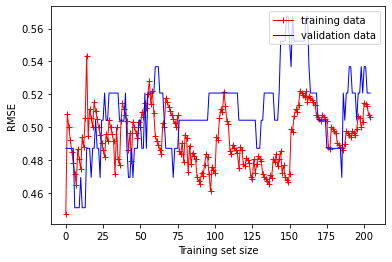

In [10]:
# improve model with AdaBoost
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(LogisticRegression(), n_estimators = 10, learning_rate = 1)
adb.fit(X_train, y_train)

y_pred = adb.predict(X_test)

evaluate(y_test, y_pred)

plot_learning_curves(adb, X_train, y_train, X_test, y_test)

The boosting did not improve the models performance. The logistic regression model was still picked for ensemble methods later on.

#### Naive Bayes
Naive Bayes was considered to be an good model choice, because it is an simple model approach and assumes independent features. Here features were selected which do not correlate or correlate only weakly. From the naive Bayes classifiers, gaussian naive bayes was selected, because the features were scaled to be bell shaped using standard scaler.

[[22  7]
 [10 20]]
              precision    recall  f1-score   support

           0       0.69      0.76      0.72        29
           1       0.74      0.67      0.70        30

    accuracy                           0.71        59
   macro avg       0.71      0.71      0.71        59
weighted avg       0.71      0.71      0.71        59

test  acc: 0.711864406779661
train acc: 0.7489361702127659


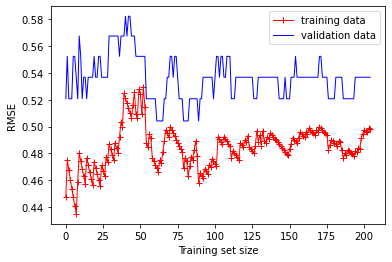

In [11]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

evaluate(y_test, y_pred)

plot_learning_curves(gnb, X_train, y_train, X_test, y_test)

The false negative prediction ratio increased in comparison to the logistic regression model. Similarly precision recall and f1 socres where lower. Overall accuracy was quite low as well. The learning curve shape looked okay, however the error was too high. Therefore, Grid search was applied to finetune the hyperparameters for the naive Bayes [https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba], however, the improvements were very small. 

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0,-10, num=100)
}
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

y_pred = nbModel_grid.predict(X_test)

evaluate(y_test, y_pred)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.0047508101621027985)
[[22  7]
 [10 20]]
              precision    recall  f1-score   support

           0       0.69      0.76      0.72        29
           1       0.74      0.67      0.70        30

    accuracy                           0.71        59
   macro avg       0.71      0.71      0.71        59
weighted avg       0.71      0.71      0.71        59



The metrics improved only slightly, which makes Naive Bayes not a good model choice in the end. Since the features are all extracted from the voice it might still be too correlated for the Naive Bayes algorithm to shine. It might work better for including parkinson related features from different source such as muscle tension, walking stiffness measurements, change in taste etc. One could argue that all measurements from a human are somewhat corellated because of originating from one system. However it was stated, that Bayes classifiers are often used in medical research with good performance. [https://scialert.net/fulltext/?doi=itj.2012.1166.1174]

#### Support vector machine
Similar approach than in logistic regression but it might be better suited for the 9 dimensions which need to be handled here.

[[28  1]
 [ 1 29]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.97      0.97      0.97        30

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

test  acc: 0.9661016949152542
train acc: 0.9404255319148936


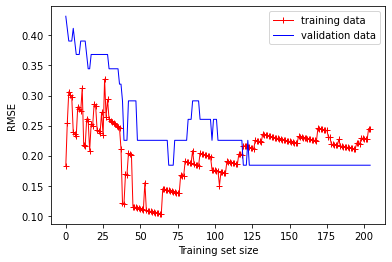

In [13]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
evaluate(y_test, y_pred)

plot_learning_curves(svm, X_train, y_train, X_test, y_test)

Best model so far, no overfitting, good performance on the training and validation data. With more data the the errors decrease and stabilize at an acceptable error level. False negative predicitions do occur but are not too frequent.

### Ensemble methods
The support vector machine model was satisfactory already, however ensemble methods are tried to see whether several simple models together result in a good model as well.

#### Extreme gradient boost classifier
Extreme gradient boost classifier Was assumed to be a promising model, since it uses boosting to learn from where the decision trees go wrong. Regularisation is already included, which is the reason for prefering it over gradient boosting. However hyperparameter tuning is necessary to get the optimal model oftentimes. [https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97]

[16:47:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:47:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:47:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:47:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([0.76923077, 0.84615385, 0.94871795, 0.79487179, 0.76923077])

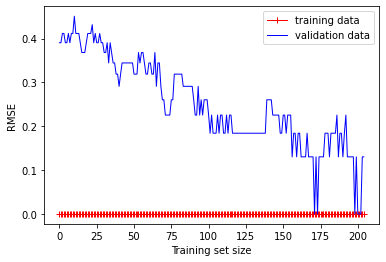

In [14]:
#xgboost classifier
xgb_model = XGBClassifier(objective='binary:logistic').fit(X_train, y_train)

# predict
xgb_y_predict = xgb_model.predict(X_test)

plot_learning_curves(xgb_model, X_train, y_train, X_test, y_test)

evaluate(y_test, xgb_y_predict)

from sklearn.model_selection import cross_val_score
cross_val_score(XGBClassifier(), X, y)

The performance metrics are the best so far, no or only few false negative predictions occur. High Recall and overall accuracy is achieved. Cross validation shows quite a range in overall accuracy. However, considering the learning curve, the model is overfitted, hyperparameter tuning is necessary to circumvent it. Hyperparameter tuning is quite extensive, since decision tree hyperparameter as well as ensemble parameters need to be fine tuned. [https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/] Tuning was conducted based on findings from this article [https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/].

[16:48:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:48:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

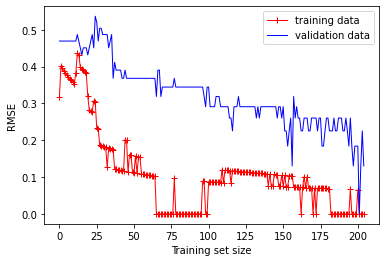

In [15]:
xgb1 = XGBClassifier(
 learning_rate =0.05, # the smaller the more accuracy, but watch out for too small value it could get stuck in a local minimum
 n_estimators=1000,
 max_depth=5, # helps to prevent overfitting as well
 min_child_weight=3, # the bigger the better to suppress overfitting
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(X_train, y_train)

# predict
xgb1_y_predict = xgb1.predict(X_test)

plot_learning_curves(xgb1, X_train, y_train, X_test, y_test)

evaluate(y_test, xgb1_y_predict)

The performance metrics remain more or less the same but overfitting is suppressed. Conducting grid search for optimal parameters would probbaly lead to even more optimal model. Especially the minimum child weight helps to circumvent overfitting.

### Ensemble method Stacking

[[28  1]
 [ 1 29]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        29
           1       0.97      0.97      0.97        30

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

test  acc: 0.9661016949152542
train acc: 0.9446808510638298


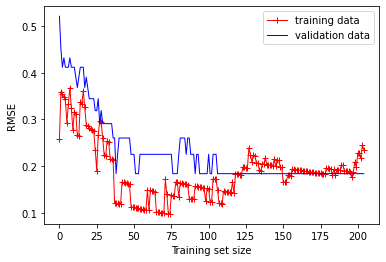

In [16]:
from sklearn.ensemble import StackingClassifier
estimators = [('logreg',logreg), ('svm', svm), ('gnb', gnb)]
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_train, y_train)

y_pred = sclf.predict(X_test)
evaluate(y_test, y_pred)
plot_learning_curves(sclf, X_train, y_train, X_test, y_test)

Similar results to the support vector machine and extreme gradient boosting are achieved, with slightly higher RMSE. Support vector machine seems to be the best model from all tested models. For final conclusion, please refer to the Final assignment notebook.